In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

# History dataset generation

In [3]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [4]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [5]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

## Create grid

In [6]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0)
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [7]:
time_grid.shape

(26, 3004, 2332)

# Compute frame bundle

In [8]:
out_condition = "borders"  # deforestation | borders


bundles = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, config.INPUT_BOXES_SIZE))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, config.INPUT_BOXES_SIZE):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                bundles.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain  some deforestation
                bundles.append(iframes.index)        

100%|██████████| 47/47 [02:15<00:00,  2.89s/it]


In [9]:
# remove bundles that represent reduced regions
bundles = [b for b in bundles if (len(b)==len(bundles[0]))]

In [10]:
# generate region and check which bundles intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 1000, 1200, 1000, 1200)

213
214
215
216
236
237
238
239
262
263
264
265
289
290
291
292


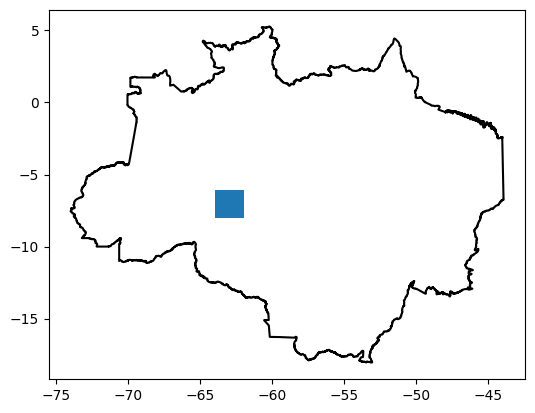

In [11]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
for i, b in enumerate(bundles):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax)
        print(i)
plt.show()

# Create final matrix

In [12]:
X = time_grid
X.shape

(26, 3004, 2332)

# Dataset & Dataloaders

In [13]:
len(bundles) * (X.shape[0] - 4)

22000

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, bundles, frames_idx):
        super(CustomDataset, self).__init__()

        self.bundles = bundles
        self.frames_idx = frames_idx
        self.X = X
        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.bundles) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):
        idx_bundle = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)

        idx_frames = self.frames_idx.loc[self.bundles[idx_bundle]]

        data = torch.tensor(
            self.X[
                idx_time:idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ]
        ).float()
        labels = torch.tensor(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ]
        ).float()
        return data, labels

In [15]:
train_data = X[-12:-4, :, :]
test_data = X[-8:, :, :]

In [16]:
train_data.shape, test_data.shape

((8, 3004, 2332), (8, 3004, 2332))

In [17]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(train_data, bundles, frames_idx),
    batch_size=50,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(test_data, bundles, frames_idx),
    batch_size=1,
    shuffle=False
)

In [18]:
trainloader.__len__()*trainloader.batch_size, testloader.__len__()*testloader.batch_size

(4000, 4000)

# Baseline Model

Just test the metrics we get when always predicting zeros.

In [58]:
# baseline
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(np.zeros(labels.shape))
    # y_pred = inputs[-1, :, :]
    base_train_err += torch.square(y_pred - labels)[:, 3:-3, 3:-3].float().sum()
base_train_err = base_train_err**0.5 / (len(trainloader)*trainloader.batch_size)
    
base_test_err = 0
for inputs, labels in testloader:
    y_pred = torch.tensor(np.zeros(labels.shape))
    # y_pred = inputs[-1, :, :]
    base_test_err += torch.square(y_pred - labels)[:, 3:-3, 3:-3].float().sum()
base_test_err = base_test_err**0.5 / (len(testloader)*testloader.batch_size)

print(f"Baseline: Train Error = {base_train_err:.6f} | Test Error = {base_test_err:.6f}")

Baseline: Train Error = 0.018567 | Test Error = 0.025985


# Model Implementation

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

 
class BasicConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.errs = []
        self.conv1 = nn.Conv2d(4, 64, kernel_size=(7,7), stride=1, padding=3)
        self.act1 = nn.Tanh()
 
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(7,7), stride=1, padding=3)
        self.act2 = nn.ReLU()
 
        self.conv3 = nn.Conv2d(64, 1, kernel_size=(7,7), stride=1, padding=3)
        self.act3 = nn.Sigmoid()
 
    def forward(self, x):
        y = self.act1(self.conv1(x))
        y = self.act2(self.conv2(y))
        y = self.act3(self.conv3(y))
        return y

In [119]:
# model initialization
model = BasicConvModel()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [120]:
for data, target in trainloader:
    break

In [121]:
data.shape, target.shape

(torch.Size([50, 4, 64, 64]), torch.Size([50, 64, 64]))

In [122]:
pred = model(data)

In [123]:
pred.shape, target.shape

(torch.Size([50, 1, 64, 64]), torch.Size([50, 64, 64]))

In [124]:
(pred[:, 0, :, :] - target).shape

torch.Size([50, 64, 64])

In [125]:
# train loop
errs = []

def train(n_epochs):
    for epoch in range(n_epochs):
        model.epoch += 1
        print(f"\nEpoch {model.epoch}")
        for inputs, labels in tqdm(trainloader):
            y_pred = model(inputs)[:, 0, :, :]
            # evaluate loss ignoring the borders
            loss = torch.square(y_pred - labels)[:, 3:-3, 3:-3].mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_err = 0
        for inputs, labels in trainloader:
            y_pred = model(inputs)[:, 0, :, :]
            train_err += torch.square(y_pred - labels)[:, 3:-3, 3:-3].detach().float().sum()
        train_err = train_err**0.5 / (len(trainloader)*trainloader.batch_size)
            
        test_err = 0
        for inputs, labels in testloader:
            y_pred = model(inputs)[:, 0, :, :]
            test_err += torch.square(y_pred - labels)[:, 3:-3, 3:-3].detach().float().sum()
        test_err = test_err**0.5 / len(testloader)
        model.errs.append([train_err, test_err])

        print(f"Epoch {model.epoch}: Train Error = {train_err:.6f} | Test Error = {test_err:.6f}")

train(10)


Epoch 1


 26%|██▋       | 21/80 [00:57<02:50,  2.89s/it]

In [ ]:
train(30)

Ganhamos do baseline?

In [ ]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_test_err)
)

(0.00089273601770401, 0.0005219615995883942)

Curva de aprendizado

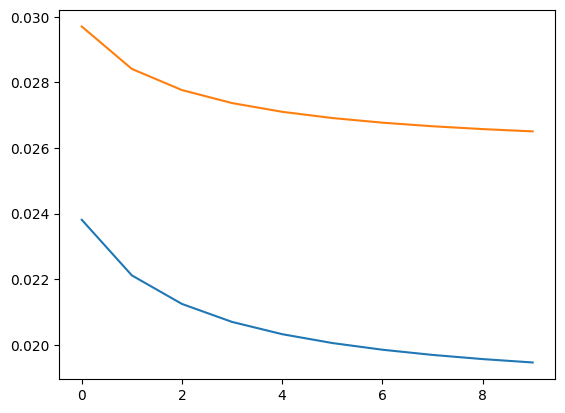

In [ ]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.plot([float(e[1]) for e in model.errs])
plt.show()

Exemplo de previsão

In [ ]:
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 1700, 1900, 300, 500)
t = 12

truth = X[t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
input_ = X[t-4:t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
pred = model(torch.tensor(input_).float())[0, :, :].detach().numpy()

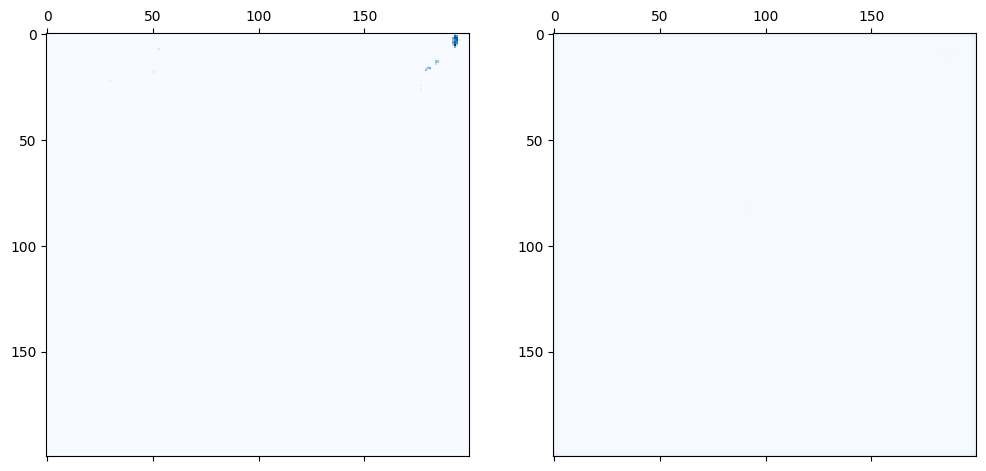

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].matshow(truth, cmap="Blues")
ax[1].matshow(pred, cmap="Blues", vmin=truth.min(), vmax=truth.max())